# Lane Detection and Object Recognition
To build a self-driving car, the perception is a very important part. Like human drivers, the computers on self-driving cars need to know the surrounding environment. In this MP, with the help from powerful open source frameworks like OpenCV, we will achieve offline lane detection. This lab will emphasize on traditional robotics approach, to give you a glimpse of the how self-driving car engineers tried to achieve computer vision before machine learning and GPU came into play. And many of those techniques are still widely used in the latest autonomous car systems.<br>  
### You only need to change the code between '## TODO' and '####' 
You can make whatever changes you want to improve the performance. We will grade the MP based on your results, not how you achieve it. BUT make sure to explain how your method works in your report. 

In [1]:
# import numpy as np
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import sys

np.set_printoptions(threshold=sys.maxsize)
print ('...')

...


We put 6 images in folder ./RightHookTestImage. You can pick one test image from them.

(1080, 1920, 3)


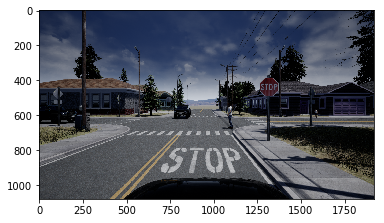

In [2]:
testImageRoot = "./RightHookTestImage/rh1.png"

rawImg = cv2.imread(testImageRoot)
print (rawImg.shape)
#Note that cv2 will read image color channel in BGR order. 
rawImg = cv2.cvtColor(rawImg,cv2.COLOR_BGR2RGB)
plt.imshow(rawImg)
plt.show()

To find the lanes, we wish to get rid of extra part in the image, like the sky, trees, and other cars. It is much easier to find the lanes from a bird view than from a normal driver's view. Here we just assume that we are on a flat road. We need to use cv2.line to find the location of 4 points on the original image and map the same 4 points on the bird view. The points we offered are just a good starting point. You can definitely find something better. <br> 
Read this useful document first:<br> https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html

Your result is supposed to be like:
<img src="./ResultImages/1.png">


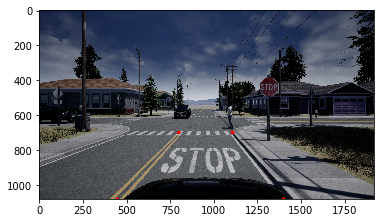

In [3]:
rawImage = cv2.imread(testImageRoot)
#try to find 4 reference points
##TO DO
# for rh3
# x1, y1 = 880, 600 # upper left
# x2, y2 = 240, 1080 # lower left
# x3, y3 = 1250, 1080 # lower right
# x4, y4 = 990, 600 # upper right

# for rh1
x1, y1 = 800, 700 # upper left
x2, y2 = 450, 1080 # lower left
x3, y3 = 1400, 1080 # lower right
x4, y4 = 1110, 700 # upper right

####

cv2.circle(rawImage,(x1,y1), 10, (0,0,255), -1)
cv2.circle(rawImage,(x2,y2), 10, (0,0,255), -1)
cv2.circle(rawImage,(x3,y3), 10, (0,0,255), -1)
cv2.circle(rawImage,(x4,y4), 10, (0,0,255), -1)

#plot 4 points on original image
plot1 = cv2.cvtColor(rawImage,cv2.COLOR_BGR2RGB)
plt.imshow(plot1)
plt.show()

In [4]:
def warpImage(img):
#(1) use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
#(2) use cv2.warpPerspective to generate warped image in bird view, 
    ## TODO    
    h,w = img.shape[:2] #width and height
    #put the 4 points you choose in last cell here 
    x1, y1 = 800, 700 # upper left
    x2, y2 = 450, 1080 # lower left
    x3, y3 = 1400, 1080 # lower right
    x4, y4 = 1110, 700 # upper right
    ####
    
    #destination points on bird view image
    dst = np.float32([(600,0),
                  (w-600,0),
                  (600,h),
                  (w-600,h)])   
    # src = np.float32([(x2,y2),(x4,y4),(x1,y1),(x3,y3)])
    # src = np.float32([(x3,y3),(x2,y2),(x4,y4),(x1,y1)])
    src = np.float32([(x1,y1),(x4,y4), (x2,y2),(x3,y3)])
    
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    ## TODO
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    ####
    
    # use cv2.warpPerspective to transform to bird view
    warpedImg = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)

    return warpedImg, M, Minv

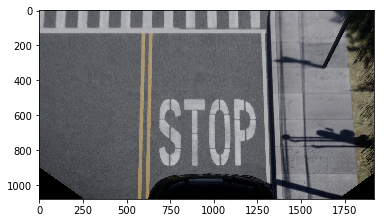

In [5]:
##test warpImage
rawImage = cv2.imread(testImageRoot)
warpedImage, M, Minv = warpImage(rawImage)

plot2 = cv2.cvtColor(warpedImage,cv2.COLOR_BGR2RGB)
plt.imshow(plot2)
plt.show()

## Color Space and Gradient Threshold For Edge Detection
In this part, you will implement multiple methods to do edge detection and distinguish the lanes pixels from the background. And you can choose whatever combinations you want to add into the image processing pipeline. We have also offered you a nice piece of test bench. Here are a few useful tips:<br>
1. Convert image to gray scale use cv2.cvtColor for all gradient methods.
2. Use image blurring to smooth over the shift caused by vibration of camera.
3. In color space method, we can assume lanes are yellow or white. So just mask the image with white and yellow.

First use Laplacian operator, which calculate the second order derievative in one single pass to detect edges.
Read the tutorial before you start: https://docs.opencv.org/3.4/d5/db5/tutorial_laplace_operator.html

In [6]:
def laplacian(img, thresh_min=0, thresh_max=20): #after you find the correct values, use them as default values  
    #1. convert the image to gray scale
    #2. Gaussian blur the image
    #3. implement laplacian edge detetion using openCV
    #4. using numpy to scale the result to uint8(0-255)
    #5. using the threshold to create a binary image and return it
    
    ## TODO
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # step 1
    img = cv2.GaussianBlur(img,(5,5),0) # step 2
    img = cv2.Laplacian(img, cv2.CV_64F, 5) # step 3
    # img = cv2.convertScaleAbs(img) # step 4
    # name your output binary image to be laplacian
    laplacian = img
    
    ####
    
    scaled_lap = np.uint8(255*laplacian/np.max(laplacian))
    binary_output = np.zeros_like(scaled_lap)
    binary_output[(scaled_lap >= thresh_min) & (scaled_lap <= thresh_max)] = 1
    
    return binary_output
print('...')

...


Then use Sobel operator, which calculate the first derivative separatly for X and Y axis. Unlike previous part, we need to apply it individually on X and Y axis. Then combine them in to one binary image output.<br>
Follow this useful tutorial: https://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/sobel_derivatives/sobel_derivatives.html

In [7]:
# def sobel(img, thresh_min=0, thresh_max=100): # use the threshold values you found to replace 0 and 255
#     #1. convert the image to gray scale
#     #2. Gaussian blur the image
#     #3. Use Sobel to find derievatives for both X and Y Axis
#     #4. Use addweight to combine the results
#     #5. Convert each pixel to unint8, then apply threshold to get binary image
#     ## TODO

#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # step 1
#     img = cv2.GaussianBlur(img,(3,3),0) # step 2
    
#     #name your result to be sobelX and sobelY
#     sobelX = cv2.Sobel(img, cv2.CV_8U, 1, 0, 3)
#     sobelY = cv2.Sobel(img, cv2.CV_8U, 0, 1, 3)
    
#     ####
    
#     combined = cv2.addWeighted(sobelX, 0.7, sobelY, 0.3, 0)
#     scaled_lap = np.uint8(255*combined/np.max(combined))
# #     scaled_lap=np.reshape(scaled_lap,[1080, 1920, 1])
# #     scaled_lap=np.tile(scaled_lap, [1,1,3])
#     # print(scaled_lap)
#     binary_output = np.zeros_like(scaled_lap)
#     binary_output[(scaled_lap >= thresh_min) & (scaled_lap <= thresh_max)] = 1
    
#     # print(combined)
#     return binary_output 
#     # return scaled_lap
# print ('...')
def sobel(img, thresh_min=19, thresh_max=255): # use the threshold values you found to replace 0 and 255
    #1. convert the image to gray scale
    #2. Gaussian blur the image
    #3. Use Sobel to find derievatives for both X and Y Axis
    #4. Use addweight to combine the results
    #5. Convert each pixel to unint8, then apply threshold to get binary image
    ## TODO
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_blur = cv2.GaussianBlur(img_gray, (13, 13), 0)
    #name your result to be sobelX and sobelY
    sobelX = cv2.Sobel(img_blur,cv2.CV_8U,1,0,3)
    sobelY = cv2.Sobel(img_blur,cv2.CV_8U,0,1,3)

    ####

    combined = cv2.addWeighted(sobelX, 0.7, sobelY, 0.3, 0)
    #scaled_lap = np.uint8(255*combined/np.max(combined)) #for some reason, scaled_lap was only containing 0s and 2s
    binary_output = np.zeros_like(combined)
    binary_output[(combined >= thresh_min) & (combined <= thresh_max)] = 1
    #for i in range(0,len(scaled_lap)):
    #	for j in range(0,len(scaled_lap[i])):
    #    	print(scaled_lap[i][j])
    return binary_output
print ('...')


...


This is a test bench for you to try different values easily. You can move the white dot to cahnge the threshold values. Try to find the optimal value sets and hard-code them at where the previous two functions are defined. You must finish previous part first before run it.

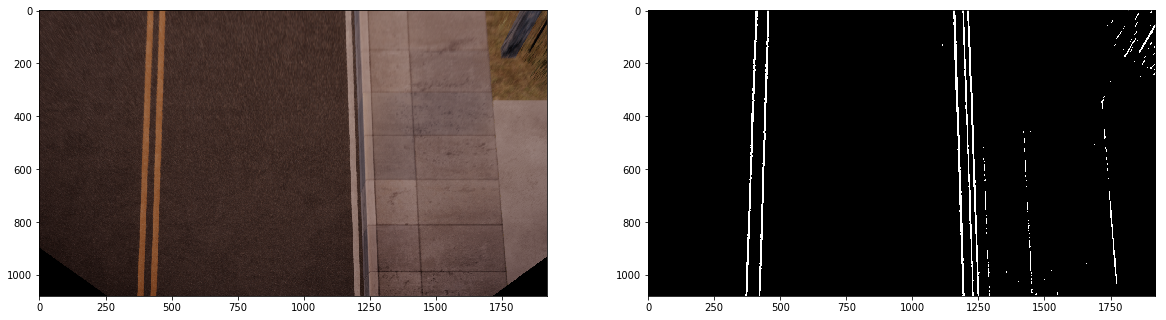

In [8]:

def fineTuning(thresh_min1,thresh_max1,thresh_min2,thresh_max2,thresh_min3,thresh_max3):
    rawImage = cv2.imread("./RightHookTestImage/rh3.png")
    warpedImage, M, Minv = warpImage(rawImage)
    
    ## TODO
    #To test different function you write, change the function name 
    # newImg = laplacian(warpedImage, thresh_min1, thresh_max1) #comment out this line when test sobel
    newImg = sobel(warpedImage, thresh_min1, thresh_max1) #comment out this line when test laplacian
    ####
    
    f = plt.figure(figsize= (20,15))
    f.add_subplot(1, 2, 1)
    plot1 = cv2.cvtColor(warpedImage,cv2.COLOR_BGR2RGB)
    plt.imshow(plot1)
    f.add_subplot(1, 2, 2)
    plt.imshow(newImg, cmap='gray')
    plt.show()
    
fineTuning(19, 255, 0, 0, 0, 0)
# interact(fineTuning, thresh_min1 = (0, 255, 1), thresh_max1 = (0,255, 1), thresh_min2 = (0,255, 1), thresh_max2 = (0, 255, 1), thresh_min3 = (0, 255, 1), thresh_max3 = (0, 255, 1))

Besides gradient method, we can also utilize the information that lane markings in united states are normally white and yellow. So we can convert the color image into a binary image, where white and yellow pixels are "1" and other colors are "0". You may use diffrent color space (RGB, LAB, HSV, HSL, YUV...), different channels and compare the effect. <br>
This link might be helpful: 
https://docs.opencv.org/3.4.3/da/d97/tutorial_threshold_inRange.html

In [36]:
def colorThres(img, thresh_min1=0,thresh_max1=255,thresh_min2=0,thresh_max2=255,thresh_min3=0,thresh_max3=255):
    # use the threshold values you found to replace 0 and 255 above
    #1. Gaussian blur the image (cv2.GaussianBlur())
    #2. Choose the color space that you like, convert image to it (cv2.cvtColor())
    #3. Apply threshold on the image to create binary image output, you might need two threshold for yellow and white
    #4. Combine results from different color spaces 
    
    ##TODO
    img = cv2.GaussianBlur(img,(3,3),0) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # print(np.mean(img))
    
    lower_w = (0, 0, 150,)
    upper_w = (31,78,255,)
    white_img = cv2.inRange(img, lower_w, upper_w)
    
    lower_y = (60, 50, 150,)
    upper_y = (180,100,255,)
    yellow_img = cv2.inRange(img, lower_y, upper_y)
    
    print(yellow_img.shape)
#     combined = np.zeros(yellow_img.shape)
#     row, col = yellow_img.shape
#     for i in range(0, row):
#         for j in range(0, col):
#             if yellow_img[i, j] > 0 or white_img[i, j] > 0:
#                 combined[i, j] = 1
    combined = np.zeros_like(yellow_img)
    combined[(white_img > 0) | (yellow_img > 0)] = 1
#     print(type(yellow_img[0,0]))
#     yellow_img=np.reshape(yellow_img,[1080, 1920, 1])
#     yellow_img=np.tile(yellow_img, [1,1,3])
#     print(yellow_img.shape)
    # plt.imshow(yellow_img)
    # yellow_img = cv2.bitwise_and(img, img, mask = yellow)
    # cv2.imshow('yellow', yellow_img)

    #name your result to be:
#     scaled_lap = np.uint8(255*yellow/np.max(yellow))
#     binary_output = np.zeros_like(scaled_lap)
#     binary_output[(scaled_lap >= thresh_min1) & (scaled_lap <= thresh_max1)] = 1
    ####
    
    # return binary_output
    return combined

Similar to the previous test bench. You need to find one set of color threshold at a time. 

(1080, 1920)


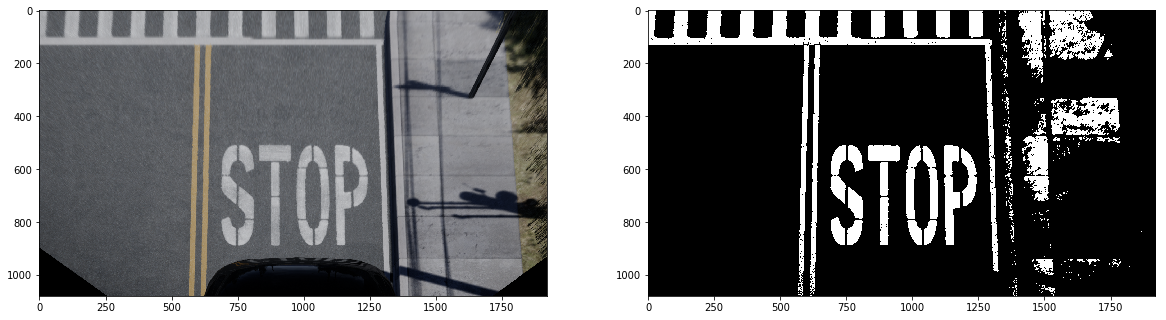

In [37]:
def fineTuning(thresh_min1,thresh_max1,thresh_min2,thresh_max2,thresh_min3,thresh_max3):
    rawImage = cv2.imread(testImageRoot)
    rawImage = cv2.cvtColor(rawImage,cv2.COLOR_BGR2RGB)
    warpedImage, M, Minv = warpImage(rawImage)
    newImg = colorThres(warpedImage,thresh_min1,thresh_max1,thresh_min2,thresh_max2,thresh_min3,thresh_max3)
    f = plt.figure(figsize= (20,15))
    f.add_subplot(1, 2, 1)
    
    plt.imshow(warpedImage)
    f.add_subplot(1, 2, 2)
    # plt.imshow(newImg)
    plt.imshow(newImg, cmap='gray')
    plt.show()
fineTuning(50, 200, 0, 0, 0, 0)  
# interact(fineTuning, thresh_min1 = (0, 255, 1), thresh_max1 = (0,255, 1), thresh_min2 = (0,255, 1), thresh_max2 = (0, 255, 1), thresh_min3 = (0, 255, 1), thresh_max3 = (0, 255, 1))

Now put your most fine-tuned and effective methods into this function. We will put it in our final image processing pipeline later.

In [38]:
def combinedEdgeDetection(img):
    ##TODO
    #you don't have to use all of them, comment what you don't need
    LapOutput = laplacian(img)
    SobelOutput = sobel(img)
    ColorOutput = colorThres(img)
    # print(ColorOutput)
    #####
    # binaryImage = ColorOutput
    #here you can use as many methods as you want. 
    binaryImage = np.zeros((img.shape[0], img.shape[1]))
    print(binaryImage.shape)
    binaryImage[(ColorOutput > 0)|(SobelOutput > 0)] = 1
    # binaryImage[(ColorOutput==1)] = 1
    return binaryImage

Test on all 6 images. Your Result should look like:
<img src="./ResultImages/2.png">

(1080, 1920)
(1080, 1920)


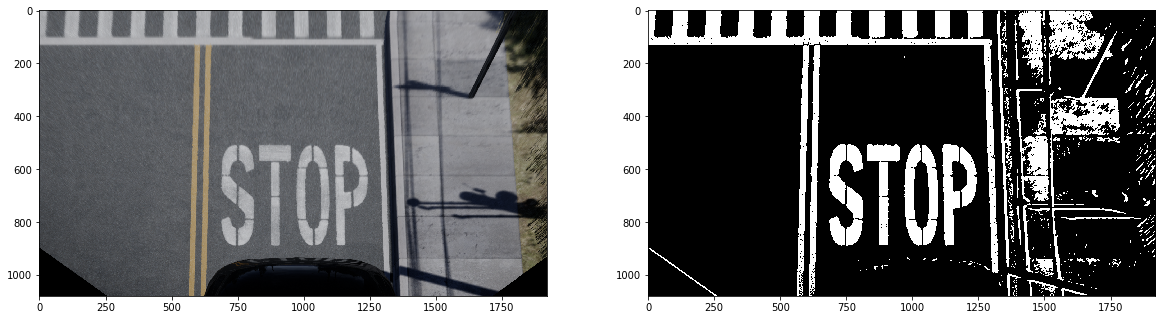

(1080, 1920)
(1080, 1920)


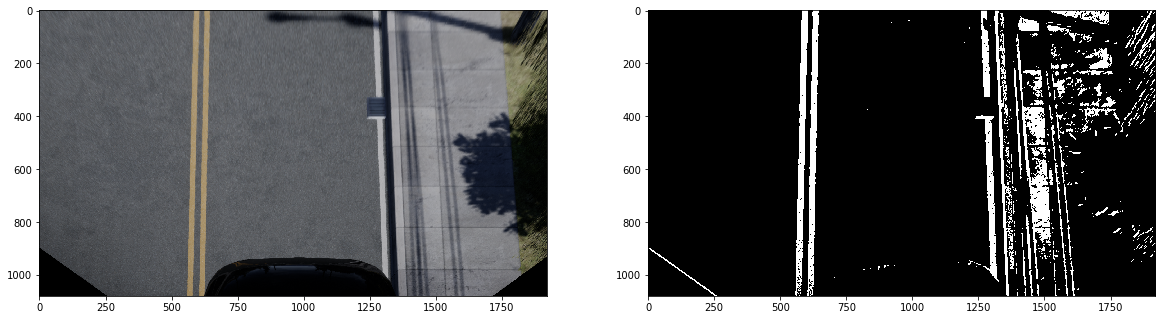

(1080, 1920)
(1080, 1920)


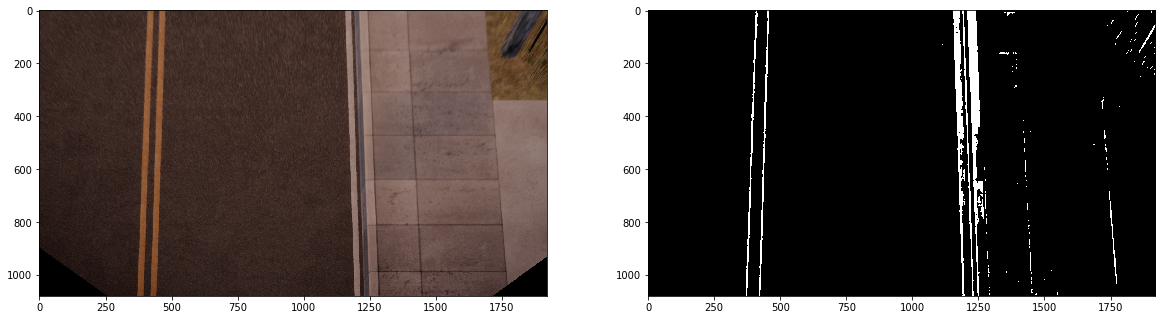

(1080, 1920)
(1080, 1920)


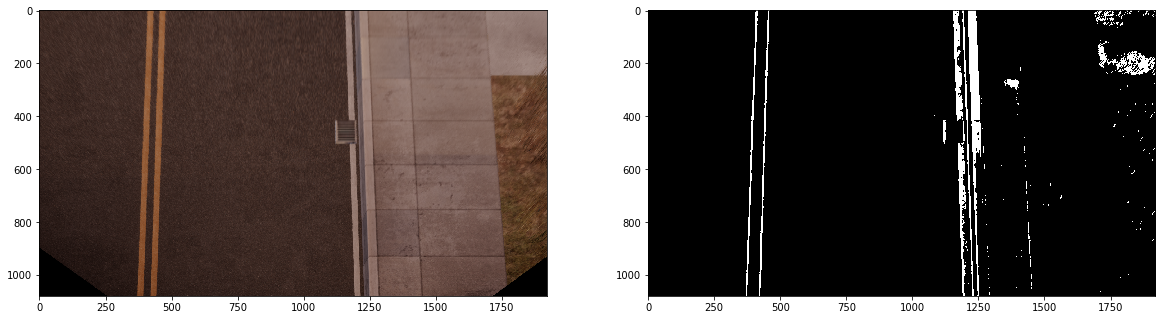

(1080, 1920)
(1080, 1920)


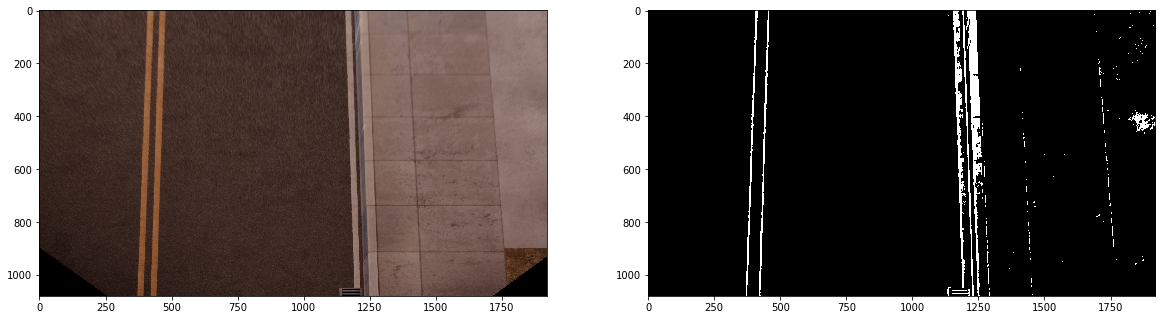

(1080, 1920)
(1080, 1920)


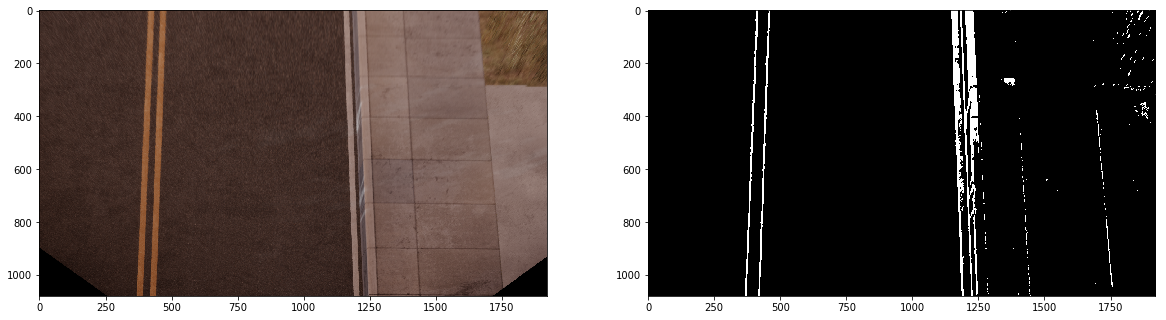

In [39]:
images = glob.glob("./RightHookTestImage/rh*.png")
for frame in images:
    img = cv2.imread(frame)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    warpedImg, M, Minv = warpImage(img)
    edgeDetectedImg = combinedEdgeDetection(warpedImg)
    
    f = plt.figure(figsize= (20,15))
    f.add_subplot(1, 2, 1)
    plt.imshow(warpedImg)
    f.add_subplot(1, 2, 2)
    plt.imshow(edgeDetectedImg,cmap='gray')
    plt.show()

### Sliding Window Summation & Convolution
With a binary bird view image, now we need to extract out the locations of two lane markings, and plot two clear lines that covers those locations. Since the lines tend to be vertical, we can slice the image into multiple horizontal layers. For each layer, we find the most dense location. <br>

Convolution is widely used in deep learning neural networks and signal processing. It works well for feature extraction. Here we can use it to find the most likely position of the center of lane markings. Convolution between two finite sequences is just the summation of products. $$(f*g)[n] = \sum_{m=-\infty}^{\infty} f[m]\cdot g[n-m]= f[n-m] \cdot g[m]$$
1. First, we need to define the height and width of sliding window and create a 1-D array of 1s to represent it. The length of array is just the length of sliding window. 
2. Then, we start from the bottom half of the rows of pixels. To find the starting points for left and right lane markings, we sum up the lower half of each column and store the sums into an 1-D array with length equals to image width. PS: use np.sum()
3. Now we can convolute the sliding window with the array of sums. Then pick the x coordinate where the convolution result is maximum, using np.convolve() and np.argmax(). We shall search from bottom to top. In the bottom area, which is the closest, we can assume that horizontal coordinates of two lines are within certain range.
4. For the other layers, we repeat the same process. But instead of sum up half of the column, we only look at a vertical piece with height equals to sliding window height for each layer. Between 2 consecutive layers, the x-coordinates of the lane markings should be relatively close. So we assume their difference to be less than a certain margin. <br>

Optional:
* Lane markings may not always be continuous. So we can assume that the lane curvature are unchanged for layers where no obvious lines can be found. 
* If the convolution result is smaller than a certain threshold, we can consider it as background noise and set it to 0.

In [13]:
# # window settings, can be changed if you want. 
# window_width = 30 
# window_height = rawImg.shape[0] / 10.0 # Break image into 10 vertical layers 
# margin = 80 # How much to shift left or right from last found line segment for searching
# window = np.ones(window_width) # Create our window template that we will use for convolutions
# convThres = 100 # filtered out back ground noise

# #Parameters for finding the start points 
# verticle_ratio = 1.0/2  
# horizontal_ratio = 0.15

# def findConvCenter(image):
    
#     image = np.uint8(255*image/np.max(image))
#     # print('image:', image.shape)
#     # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     #windowCentroids = [] #Output array that store the (left,right) window centroid positions per level
#     leftCentroids = []
#     rightCentroids = []

#     # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
#     # and then np.convolve the vertical image slice with the window template 
#     ## TODO
#     # preprocess the vertical slice
#     row = image.shape[1]
#     col = image.shape[0]
# #     print(image[:, 0].shape)
#     vertical_slice = np.sum(image[:int(col/2), :], axis = 0)
# #     print(image[:, (int)(col - window_height):].shape)
# #     print(vertical_slice.shape)
#     vertical_slice = np.convolve(vertical_slice, window, mode = 'same')
# #     print('vertical_slice:', vertical_slice.shape)

#     # find left and right starting points
#     leftCenterX = np.argmax(vertical_slice[:int(row/2)])
#     rightCenterX = np.argmax(vertical_slice[int(row/2):]) + int(row/2)
#     leftCenterY = col - window_height / 2
#     rightCenterY = col - window_height / 2
# #     print('left center x:', leftCenterX)
# #     print('right center x:', rightCenterX)
#     ####
#     # Add what we found for the first layer
#     leftCentroids.append((leftCenterX, leftCenterY))
#     rightCentroids.append((rightCenterX, rightCenterY))

#     #Count how many empty layers for left and right line
#     leftEmptyCount, rightEmptyCount = 0, 0
    
#     # Go through each layer looking for max pixel locations
#     for i in range(1,(int)(image.shape[0]/window_height)):
#         # convolve the window into the vertical slice of the image
#         ## TODO
#         vertical_slice = np.sum(image[(int(col - window_height * (i+1))):(int(col - window_height * i)), :], axis = 0)
# #         print(image[:, (int(col - window_height * (i+1))):(int(col - window_height * i))].shape)
# #         print(vertical_slice.shape)
#         vertical_slice = np.convolve(vertical_slice, window, mode = 'same')
#         print(vertical_slice.shape)

#         ####
#         # Find the best left centroid by using past left center as a reference
#         # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
#         ## TODO
#         (last_leftx, a) = leftCentroids[-1]
#         (last_rightx, a) = rightCentroids[-1]
# #         print('i = ', i, ', last_leftx = ', last_leftx, ', last_rightx = ', last_rightx)
# #         print(vertical_slice[(int(last_rightx - margin/2)):(int(last_rightx + margin/2))].shape)
#         leftCenterX = np.argmax(vertical_slice[(int(last_leftx - margin/2)):(int(last_leftx + margin/2))])\
#         + int(last_leftx - margin/2)
#         rightCenterX = np.argmax(vertical_slice[(int(last_rightx - margin/2)):(int(last_rightx + margin/2))])\
#         + int(last_rightx - margin/2)
        
#         leftCenterY = col - window_height * i / 2
#         rightCenterY = leftCenterY
        
#         ####   
#         # Find the best right centroid by using past right center as a reference
#         #if last layer not found, extend margin and reuse old refrence
#         ## TODO
        
#         ####
#         # Add what we found for that layer
#         ## TODO
#         leftCentroids.append((leftCenterX, leftCenterY))
#         rightCentroids.append((rightCenterX, rightCenterY))

#         ####
#     ####
#     #return two list of tuples 
#     return leftCentroids, rightCentroids

# print ('...')
# window settings, can be changed if you want.
window_width = 30
window_height = rawImg.shape[0] / 10.0 # Break image into 10 vertical layers
margin = 80 # How much to shift left or right from last found line segment for searching
window = np.ones(window_width) # Create our window template that we will use for convolutions
convThres = 100 # filtered out back ground noise
#Parameters for finding the start points
vertical_ratio = 1.0/2 
horizontal_ratio = 0.15
def findConvCenter(image):

    image = np.uint8(255*image/np.max(image))
    #windowCentroids = [] #Output array that store the (left,right) window centroid positions per level
    leftCentroids = []
    rightCentroids = []
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template
    ## TODO
    image_bottom = image[int(image.shape[0]/2):(image.shape[0]-1),:]
    sum_arr = np.sum(image_bottom,axis=0,dtype=np.int32)
    conv_arr = np.convolve(sum_arr,window,'same')

    leftCenterX = -1
    rightCenterX = -1

    center_coord = image.shape[1]/2
    while(leftCenterX == -1 or rightCenterX == -1):
        max_val = np.argmax(conv_arr)
        if(max_val < center_coord+450 and max_val > center_coord-450):
            if(max_val < center_coord and leftCenterX == -1):
                leftCenterX = max_val
            elif(max_val >= center_coord and rightCenterX == -1):
                rightCenterX = max_val
        conv_arr[max_val] = 0
    #450 pixels to either side of center

    leftCenterY = image.shape[0] - (window_height/2)
    rightCenterY = leftCenterY
    ####
    # Add what we found for the first layer
    leftCentroids.append((leftCenterX, leftCenterY))
    rightCentroids.append((rightCenterX, rightCenterY))
    #Count how many empty layers for left and right line
    leftEmptyCount, rightEmptyCount = 0, 0

    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        ## TODO
        image_window = image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height-1),:]
        sum_arr = np.sum(image_window,axis=0,dtype=np.int32)
        conv_arr = np.convolve(sum_arr,window,'same')
        ####
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        ## TODO
        left_coord = leftCenterX-margin
        if(left_coord < 0):
            left_coord = 0
        right_coord = leftCenterX+margin
        if(right_coord >= image.shape[1]):
            right_coord = image.shape[1] - 1
        conv_arr_left = conv_arr[left_coord:right_coord]
        newleftCenterX = np.argmax(conv_arr_left)
        if(conv_arr_left[newleftCenterX] < convThres):
            leftCenterX = leftCenterX
        else:
            leftCenterX = newleftCenterX + left_coord
        #print(left_coord,right_coord, leftCenterX, conv_arr_left)
        ####  
        # Find the best right centroid by using past right center as a reference
        #if last layer not found, extend margin and reuse old refrence
        ## TODO
        left_coord = rightCenterX-margin
        if(left_coord < 0):
            left_coord = 0
        right_coord = rightCenterX+margin
        if(right_coord >= image.shape[1]):
            right_coord = image.shape[1] - 1
        conv_arr_right = conv_arr[left_coord:right_coord]
        newrightCenterX = np.argmax(conv_arr_right)
        if(conv_arr_right[newrightCenterX] < convThres):
            rightCenterX = rightCenterX
        else:
            rightCenterX = newrightCenterX + left_coord
        ####
        # Add what we found for that layer
        ## TODO
        #print(leftCenterX, leftCenterY, rightCenterX, rightCenterY)
        leftCenterY = leftCenterY - window_height
        rightCenterY = leftCenterY
        leftCentroids.append((leftCenterX, leftCenterY))
        rightCentroids.append((rightCenterX, rightCenterY))
        ####
    ####
    #return two list of tuples
    return leftCentroids, rightCentroids
print ('...')


...


This part is provided for you. It will draw the predicted lines on warped (bird view) image. Your result image should look like:
<img src="./ResultImages/3.png">

In [14]:
def window_mask(width, height, img_ref, centerX, centerY):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-centerY-height/2):int(img_ref.shape[0]-centerY+height/2),max(0,int(centerX-width/2)):min(int(centerX+width/2),img_ref.shape[1])] = 1
    return output

def plotWindows(warped):
    leftCentroids, rightCentroids= findConvCenter(warped)
    
    # Points used to draw all the left and right windows
    r_points = np.zeros_like(warped)
    l_points = np.zeros_like(warped)    
    
    if len(leftCentroids) > 0 and len(rightCentroids) > 0:
        if len(leftCentroids) > 0:
            # Go through each level and draw the windows 
            for level in range(0,len(leftCentroids)):
                # Window_mask is a function to draw window areas
                l_mask = window_mask(window_width,window_height,warped,leftCentroids[level][0],leftCentroids[level][1])
                # Add graphic points from window mask here to total pixels found 
                l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255

        if len(rightCentroids) > 0:
            # Go through each level and draw the windows 
            for level in range(0,len(rightCentroids)):
                # Window_mask is a function to draw window areas
                r_mask = window_mask(window_width,window_height,warped,rightCentroids[level][0],rightCentroids[level][1])
                # Add graphic points from window mask here to total pixels found 
                r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
        print('warpage:', type(warpage))
        print('template:', type(template))
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
    #If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    return output

In [15]:
images = glob.glob("./RightHookTestImage/rh*.png")#("test_images/test*.jpg")
for frame in images:
    img = cv2.imread(frame)
    #undistortedImg = cv2.undistort(img, mtx, dist, None, mtx)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    warpedImg, M, Minv = warpImage(img)
    edgeDetectedImg = combinedEdgeDetection(warpedImg)
    plotedLinesImg = plotWindows(edgeDetectedImg)
    
    f = plt.figure(figsize= (20,15))
    f.add_subplot(1, 2, 1)

    plt.imshow(warpedImg)
    f.add_subplot(1, 2, 2)
    plt.imshow(plotedLinesImg)
plt.show()

(1080, 1920)
(1080, 1920)
warpage: <class 'numpy.ndarray'>
template: <class 'numpy.ndarray'>


error: OpenCV(4.0.0) C:\projects\opencv-python\opencv\modules\core\src\arithm.cpp:687: error: (-5:Bad argument) When the input arrays in add/subtract/multiply/divide functions have different types, the output array type must be explicitly specified in function 'cv::arithm_op'


### Solve the Equation 
We can simplfy the two lane markings as two first-order polynomial equations in the form of: $$y = a*x^2 + b*x + c$$ <br>
Luckily, we can use np.polyfit to solve the equation. The non-zero output coordinates from previous part will be the input for this function. Then use cv2.fillPoly to draw the line back to warped image.

In [15]:
def drawPoly(originImg, warpImg, leftCentroids, rightCentroids, Minv):
    #Generate polynomial functions
    ##TO DO
    h,w = warpImg.shape[:2]
    leftX = np.array([i[0] for i in leftCentroids])
    leftY = np.array([i[1] for i in leftCentroids])
    left_eq = np.polyfit(leftX,leftY,2)
    rightX = np.array([i[0] for i in rightCentroids])
    rightY = np.array([i[1] for i in rightCentroids])
    right_eq = np.polyfit(rightX,rightY,2)
    ####

    # Generate y values for plotting
    plotY = np.linspace(0, warpImg.shape[0]-1, warpImg.shape[0])
    # Generate X values for polynomial line
    ## TO DO
    leftPlotX = ((left_eq[1]*-1) + np.sqrt(np.abs(left_eq[1]**2 - 4*left_eq[0]*(left_eq[2]-plotY)))) / (2 * left_eq[0])
    rightPlotX = ((right_eq[1]*-1) + np.sqrt(np.abs(right_eq[1]**2 - 4*right_eq[0]*(right_eq[2]-plotY)))) / (2 * right_eq[0])

    ####

    #filter out the out of boundary points
    ##TO DO
    width = warpImg.shape[1]
    leftPlotX[leftPlotX<0] = 0
    leftPlotX[leftPlotX>=width] = width-1
    rightPlotX[rightPlotX<0] = 0
    rightPlotX[rightPlotX>=width] = width-1
    ####

    #Generate (X,Y) points for plotting
    leftPts = np.array([np.transpose(np.vstack([leftPlotX, plotY]))])
    rightPts = np.array([np.flipud(np.transpose(np.vstack([rightPlotX, plotY])))])
    points = np.hstack((leftPts, rightPts))
    #plot to warped image
    ##To DO
    #warpedpoints = cv2.warpPerspective(points, Minv, (w,h), flags=cv2.INTER_LINEAR)
    plottedImg = cv2.fillPoly(warpImg,np.int32([points]),255)
    warpedImg = cv2.warpPerspective(plottedImg, Minv, (w,h), flags=cv2.INTER_LINEAR)
    newImg = cv2.addWeighted(originImg, 1, warpedImg, .5, 0)
    ####

    #return the new image and the coefficients of two polynomial equations
    return newImg, leftPlotX, rightPlotX
print ('...')


...


Just like before, we need to test our implementation before use it on our final pipeline. Draw the lane markings on original image after another perspective transformation. You don't need to change anything here. Your result should be similar to this:
<img src="./ResultImages/4.png">

In [9]:
images = glob.glob("./RightHookTestImage/rh*.png")
for frame in images:
    img = cv2.imread(frame)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    warpedImg, M, Minv = warpImage(img)
    edgeDetectedImg = combinedEdgeDetection(warpedImg)
    leftCentroids, rightCentroids = findConvCenter(edgeDetectedImg)
    plotedLinesImg, leftX, rightX = drawPoly(img, warpedImg, leftCentroids, rightCentroids, Minv)
    
    f = plt.figure(figsize= (20,15))
    f.add_subplot(1, 2, 1)
    plt.imshow(img)
    f.add_subplot(1, 2, 2)
    plt.imshow(plotedLinesImg)
plt.show()

Combine the functions to get the pipline. 

In [17]:
def imagePipeline(img):
    img = cv2.resize(img, (1080, 720))
    warpedImg, M, Minv = warpImage(undistortedImg)
    edgeDetectedImg = combinedEdgeDetection(warpedImg)
    leftCentroids, rightCentroids = findConvCenter(edgeDetectedImg)
    imgOut, leftX, rightX = drawPoly(undistortedImg, warpedImg, leftCentroids, rightCentroids, Minv)
    return imgOut
    
print ('...')

...


Congratulations! It is a great achievement to build a Lane Detection System! Now we can to test our code in RightHook Simulator. See detailed instruction on our website:
https://publish.illinois.edu/safe-autonomy/ <br>
Also, don't forgot the report! You need to submit the finished jupyter file (.ipynb) with the results and the report (pdf) to Compass 2g. Please submit a zip file with name "netid1_netid2_mp1". <br>
Finally, most importantly, take a photo of your simulation result and post it on your Facebook so your friends know how cool this course is!